# Library Import

In [1]:
import numpy as np
from scipy.optimize import least_squares, minimize
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error, r2_score)
import matplotlib.pyplot as plt

# Load Data

t: time  
f: failures  
cum_f: cumulative failures

In [2]:
data = np.loadtxt('J1.csv', delimiter=',', skiprows=1, dtype=int)
data = np.insert(data, 0, [0, 0, 0], axis=0)

In [3]:
t = data[:, 0]
f = data[:, 1]
cum_f = data[:, 2]

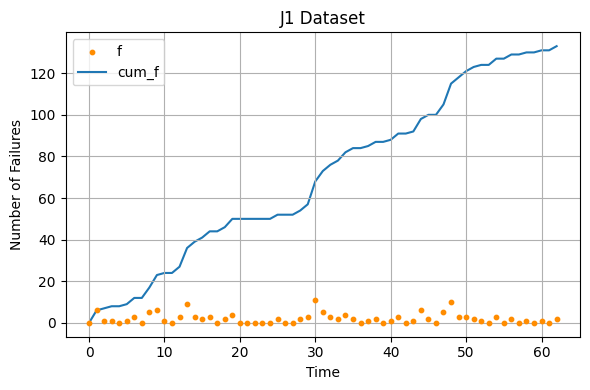

In [4]:
plt.figure(figsize=(6, 4))

plt.scatter(t, f, color='darkorange', s=10, label='f', zorder=2)
plt.plot(t, cum_f, label='cum_f', zorder=1)

plt.title('J1 Dataset')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

# Estimation

Preparation functions for parameter estimation

In [5]:
tiny = np.finfo(float).tiny  # Prevent log calculation errors (avoid log(0))


# Delayed S-Shape model function
def delayed_s(t, a, b):
    return a * (1 - (1 + b * t) * np.exp(-b * t))


# Residual function for LSM estimation using Delayed S-Shape model
def delayed_s_lsm(params, t, cum_f):
    a, b = params
    return delayed_s(t, a, b) - cum_f


# Function to estimate parameter 'a' of the Delayed S-Shape model
def delayed_s_a(t, f, b):
    a = f / (1 - (1 + b * t) * np.exp(-b * t))
    return a


# Negative log-likelihood function for the Delayed S-Shape model
def delayed_s_nll(params, t, f):
    b = params
    a = np.sum(f) / (1 - (1 + b * t[-1]) * np.exp(-b * t[-1]))

    term1 = a * ((1 + b * t[:-1]) * np.exp(-b * t[:-1])
                 - (1 + b * t[1:]) * np.exp(-b * t[1:]))
    term1[term1 < tiny] = tiny
    log_term1 = f[1:] * np.log(term1)

    term2 = a * ((1 + b * t[0]) * np.exp(-b * t[0])
                 - (1 + b * t[-1]) * np.exp(-b * t[-1]))

    log_facs = [np.sum([np.log(j) for j in range(1, i+1)]) for i in f[1:]]

    loglikelihood = np.sum(log_term1) - term2 - np.sum(log_facs)
    return -loglikelihood

Setup variables for parameter estimation

In [6]:
eps = np.sqrt(np.finfo(float).eps)  # Small epsilon to avoid division by zero

# Parameter initialization and bounds for LSM estimation
lsm_init_guess = [cum_f[-1] * 1.5, 0.1]
lsm_bounds = ([cum_f[-1], eps], [np.inf, np.inf])

# Parameter initialization and bounds for MLE estimation
mle_init_guess = [0.1]
mle_bounds = [(eps, np.inf)]

## LSM

### Trust Region Reflective algorithm

In [7]:
result = least_squares(delayed_s_lsm, lsm_init_guess, args=(t, cum_f),
                       method='trf', bounds=lsm_bounds)

trf_a, trf_b = result.x
print(f'a: {trf_a}, b: {trf_b}')

a: 162.93018698568068, b: 0.049298638348217474


In [8]:
f_pred = delayed_s(t, trf_a, trf_b)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 47.757356670007994
RMSE: 6.910669770001168
MAE: 5.851265911456237
MAPE: 0.1780266024831033
R2 score: 0.971466474973414


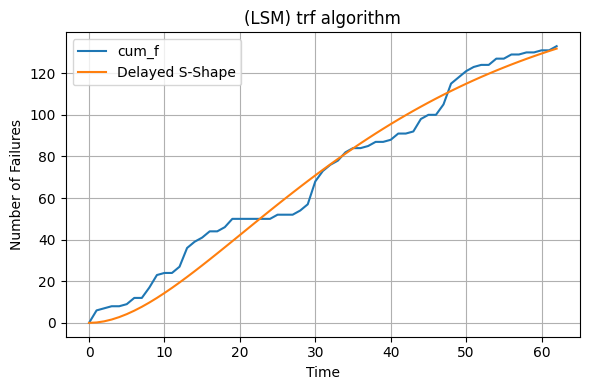

In [9]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Delayed S-Shape')

plt.title('(LSM) trf algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### dogleg algorithm

In [10]:
result = least_squares(delayed_s_lsm, lsm_init_guess, args=(t, cum_f),
                       method='dogbox', bounds=lsm_bounds)

dogbox_a, dogbox_b = result.x
print(f'a: {dogbox_a}, b: {dogbox_b}')

a: 162.93046351897343, b: 0.04929853538302403


In [11]:
f_pred = delayed_s(t, dogbox_a, dogbox_b)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 47.757356667539874
RMSE: 6.9106697698225945
MAE: 5.8512555070176155
MAPE: 0.17802668268993146
R2 score: 0.9714664749748886


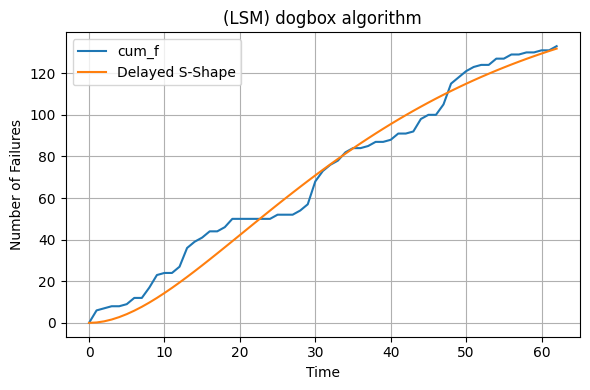

In [12]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Delayed S-Shape')

plt.title('(LSM) dogbox algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

## MLE

### Nelder-Mead algorithm

In [13]:
result = minimize(delayed_s_nll, mle_init_guess, args=(t, f),
                  method='Nelder-Mead', bounds=mle_bounds)

nelder_mead_b = result.x[0]
nelder_mead_a = delayed_s_a(t[-1], np.sum(f), nelder_mead_b)
print(f'a: {nelder_mead_a}, b: {nelder_mead_b}')

a: 160.5522644194289, b: 0.0515625000000001


In [14]:
f_pred = delayed_s(t, nelder_mead_a, nelder_mead_b)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 51.40614660944161
RMSE: 7.1698079897192235
MAE: 6.073536496522997
MAPE: 0.17662139840948726
R2 score: 0.9692864372512054


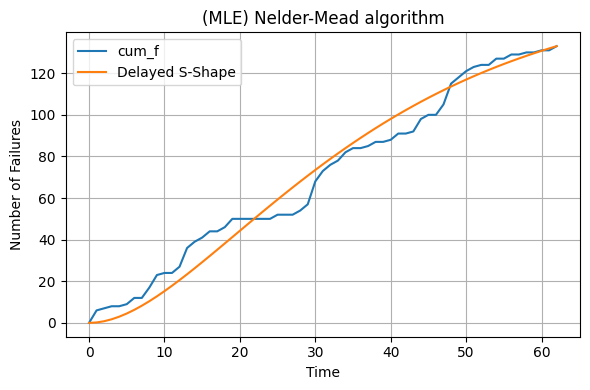

In [15]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Delayed S-Shape')

plt.title('(MLE) Nelder-Mead algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Powell algorithm

In [16]:
result = minimize(delayed_s_nll, mle_init_guess, args=(t, f),
                  method='Powell', bounds=mle_bounds)

powell_b = result.x[0]
powell_a = delayed_s_a(t[-1], np.sum(f), powell_b)
print(f'a: {powell_a}, b: {powell_b}')

a: 160.61907810770288, b: 0.0515200206043144


In [17]:
f_pred = delayed_s(t, powell_a, powell_b)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 51.317031117062726
RMSE: 7.163590658117109
MAE: 6.068025336205357
MAPE: 0.17662888755053813
R2 score: 0.9693396809671343


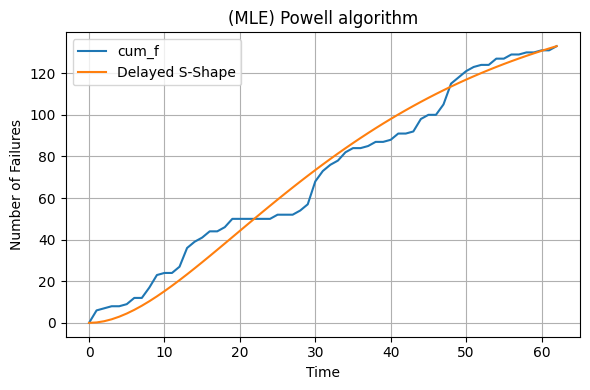

In [18]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Delayed S-Shape')

plt.title('(MLE) Powell algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### L-BFGS-B algorithm

In [19]:
result = minimize(delayed_s_nll, mle_init_guess, args=(t, f),
                  method='L-BFGS-B', bounds=mle_bounds)

l_bfgs_b_b = result.x[0]
l_bfgs_b_a = delayed_s_a(t[-1], np.sum(f), l_bfgs_b_b)
print(f'a: {l_bfgs_b_a}, b: {l_bfgs_b_b}')

a: 160.6004149247497, b: 0.05153187515642326


In [20]:
f_pred = delayed_s(t, l_bfgs_b_a, l_bfgs_b_b)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 51.3417843796179
RMSE: 7.1653181631814435
MAE: 6.069563662492541
MAPE: 0.17662680801297373
R2 score: 0.9693248916679381


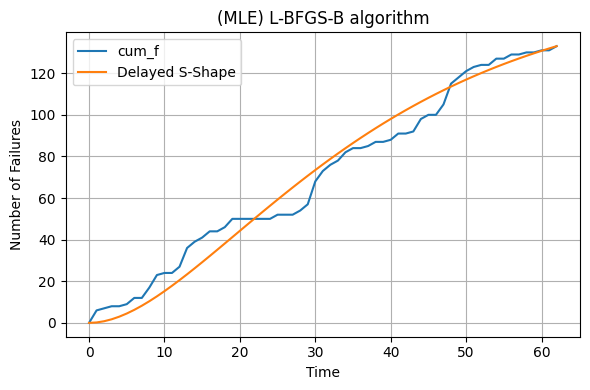

In [21]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Delayed S-Shape')

plt.title('(MLE) L-BFGS-B algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### truncated Newton (TNC) algorithm

In [22]:
result = minimize(delayed_s_nll, mle_init_guess, args=(t, f),
                  method='TNC', bounds=mle_bounds)

tnc_b = result.x[0]
tnc_a = delayed_s_a(t[-1], np.sum(f), tnc_b)
print(f'a: {tnc_a}, b: {tnc_b}')

a: 160.6030258968214, b: 0.051530216183220366


In [23]:
f_pred = delayed_s(t, tnc_a, tnc_b)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 51.33831491199824
RMSE: 7.165076057656209
MAE: 6.0693483992534505
MAPE: 0.17662709951745953
R2 score: 0.96932696456619


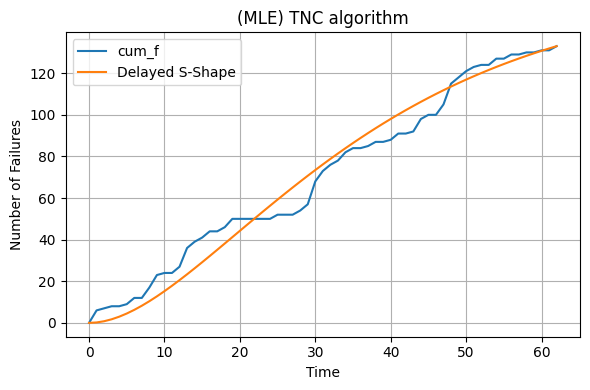

In [24]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Delayed S-Shape')

plt.title('(MLE) TNC algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Constrained Optimization BY Quadratic Approximations (COBYQA) algorithm

In [25]:
result = minimize(delayed_s_nll, mle_init_guess, args=(t, f),
                  method='COBYQA', bounds=mle_bounds)

cobyqa_b = result.x[0]
cobyqa_a = delayed_s_a(t[-1], np.sum(f), cobyqa_b)
print(f'a: {cobyqa_a}, b: {cobyqa_b}')

a: 160.60040835850896, b: 0.05153187932873171


In [26]:
f_pred = delayed_s(t, cobyqa_a, cobyqa_b)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 51.341793107524104
RMSE: 7.165318772219705
MAE: 6.069564203871727
MAPE: 0.1766268072796424
R2 score: 0.9693248864532875


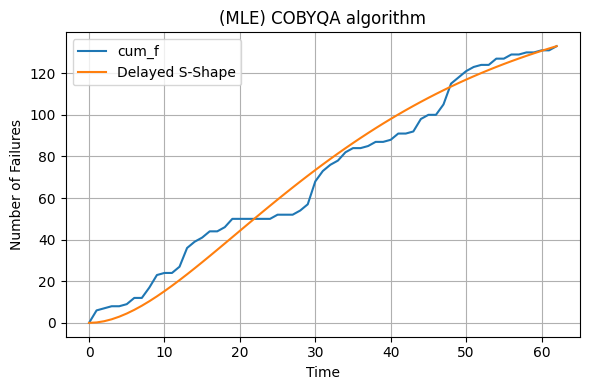

In [27]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Delayed S-Shape')

plt.title('(MLE) COBYQA algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Sequential Least Squares Programming (SLSQP)

In [28]:
result = minimize(delayed_s_nll, mle_init_guess, args=(t, f),
                  method='SLSQP', bounds=mle_bounds)

slsqp_b = result.x[0]
slsqp_a = delayed_s_a(t[-1], np.sum(f), slsqp_b)
print(f'a: {slsqp_a}, b: {slsqp_b}')

a: 160.5984195646025, b: 0.051533143094274154


In [29]:
f_pred = delayed_s(t, slsqp_a, slsqp_b)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 51.3444372457842
RMSE: 7.165503279308733
MAE: 6.069728182623107
MAPE: 0.17662658511221893
R2 score: 0.9693233066634818


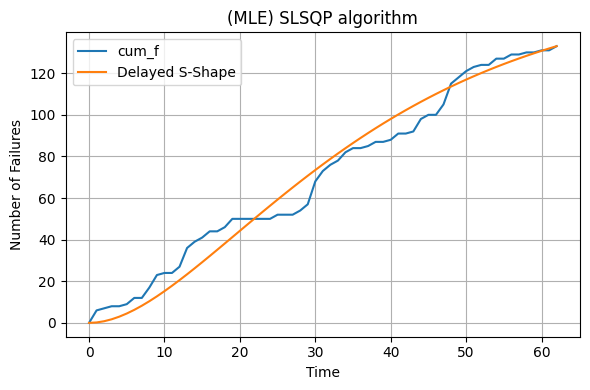

In [30]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Delayed S-Shape')

plt.title('(MLE) SLSQP algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Constrained Trust-Region algorithm

In [31]:
result = minimize(delayed_s_nll, mle_init_guess, args=(t, f),
                  method='trust-constr', bounds=mle_bounds)

trust_constr_b = result.x[0]
trust_constr_a = delayed_s_a(t[-1], np.sum(f), trust_constr_b)
print(f'a: {trust_constr_a}, b: {trust_constr_b}')

a: 160.6004177856456, b: 0.05153187333855846


In [32]:
f_pred = delayed_s(t, trust_constr_a, trust_constr_b)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 51.34178057689355
RMSE: 7.165317897825158
MAE: 6.069563426614915
MAPE: 0.17662680833248412
R2 score: 0.9693248939399469


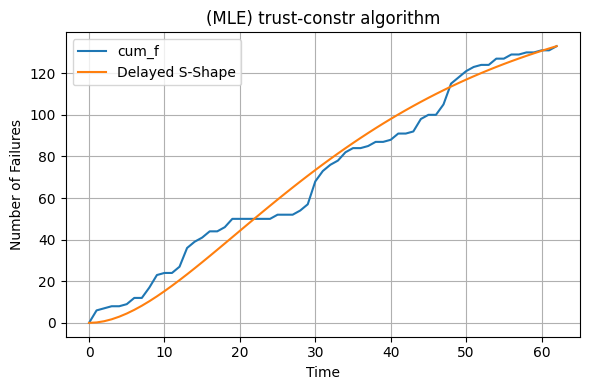

In [33]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Delayed S-Shape')

plt.title('(MLE) trust-constr algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()